# CLIP-Dissect
**Keywords**: Neuron-level Interpretability, Network Dissection

**About the dataset**:

* We use the standard [CIFAR100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) here which contains 60k RGB images of size $32\times 32$ belonging to 100 classes.

**Agenda**:

* In this programming challenge, we will reproduce the results of Fig. 4 from [CLIP-Dissect](https://arxiv.org/pdf/2204.10965.pdf).
* In this particular experiment, the neurons of the last layer of an ImageNet1k-pretrained ResNet50 are labeled using the CIFAR100 dataset as the probing dataset.
* We give some starter code that installs required dependencies and clones the original code release and changes the directory to it, so that you can import any files from that folder.

**Note:**
* A note on working with GPU:
  * Take care that whenever declaring new tensors, set `device=device` in parameters.
  * You can also move a declared torch tensor/model to device using `.to(device)`.
  * To move a torch model/tensor to cpu, use `.to('cpu')`
  * Keep in mind that all the tensors/model involved in a computation have to be on the same device (CPU/GPU).
* Run all the cells in order.
* **Do not edit** the cells marked with !!DO NOT EDIT!!
* Only **add your code** to cells marked with !!!! YOUR CODE HERE !!!!
* Do not change variable names, and use the names which are suggested.

In [1]:
# !!DO NOT EDIT!!
# !git clone https://github.com/Trustworthy-ML-Lab/CLIP-dissect
# !pip install ftfy regex
import os
import torch
import pandas as pd

import clip
import utils
import data_utils
import similarity

from matplotlib import pyplot as plt

### **(a) Reproducing Fig. 4 results from CLIP-Dissect**

* The reported results show that CLIP-Dissect can assign labels that are not present in the probing dataset. This is shown for the last layer neurons of an ImageNet1k-pretrained ResNet50 model with CIFAR100 as the probing dataset. Reproduce and verify these results.
* You can re-use the code used in [this notebook](https://github.com/Trustworthy-ML-Lab/CLIP-dissect/blob/main/experiments/fig4.ipynb) from the original repo.
* The original code release does not display the ground-truth class but you can print this as instructed below. This is for completeness of the result.
    * The ground-truth labels of the last layer neurons are simply the class names from ImageNet1k (ordered as per `data/imagenet_labels.txt` in the [original code release](https://github.com/Trustworthy-ML-Lab/CLIP-dissect)).

In [2]:
# !!! YOUR CODE HERE !!!
clip_name = 'ViT-B/16'
target_name = 'resnet50'
target_layer = 'layer1'
d_probe = 'cifar100_train'
concept_set = 'data/imagenet_labels.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi
ids_to_check = [131, 132]


In [4]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer],
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size,
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/250 [00:00<?, ?it/s]

In [3]:
save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                             text_save_name, similarity_fn, device=device)

with open(concept_set, 'r') as f: 
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

FileNotFoundError: [Errno 2] No such file or directory: 'saved_activations/cifar100_train_resnet50_layer1.pt'

In [4]:
img_lbl = os.path.join("data", "imagenet_labels.txt")
with open(img_lbl, "r") as f:
    lbls = f.readlines()
f.close

idx_one = lbls[131]
idx_two = lbls[132]

In [5]:
import re
def lbl_rgx(string):
    comma_index = string.find(",")
    return string[:comma_index]

idx_one = lbl_rgx(idx_one)
print(idx_one)
idx_two = lbl_rgx(idx_two)
print(idx_two)

little blue heron
American egret



 Layer:fc Neuron:131

 Ground Truth:  little blue heron
1st description: little blue heron, Egretta caerulea, sim:3.619
2nd description: European gallinule, Porphyrio porphyrio, sim:2.704
3rd description: African grey, African gray, Psittacus erithacus, sim:2.480
2 most highly activating images in D_probe:


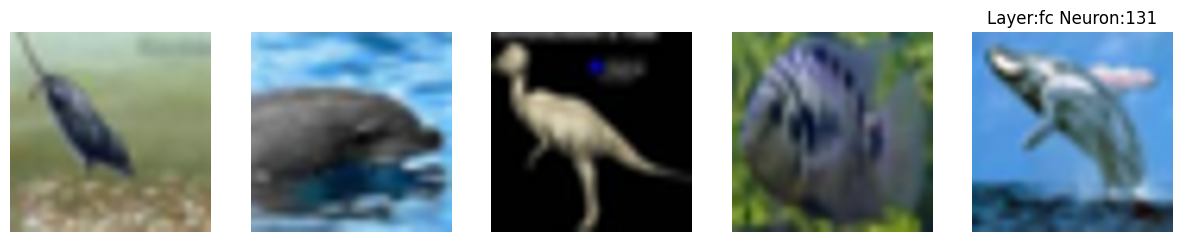


 Layer:fc Neuron:132

 Ground Truth:  American egret
1st description: American egret, great white heron, Egretta albus, sim:3.234
2nd description: little blue heron, Egretta caerulea, sim:2.525
3rd description: spoonbill, sim:2.446
2 most highly activating images in D_probe:


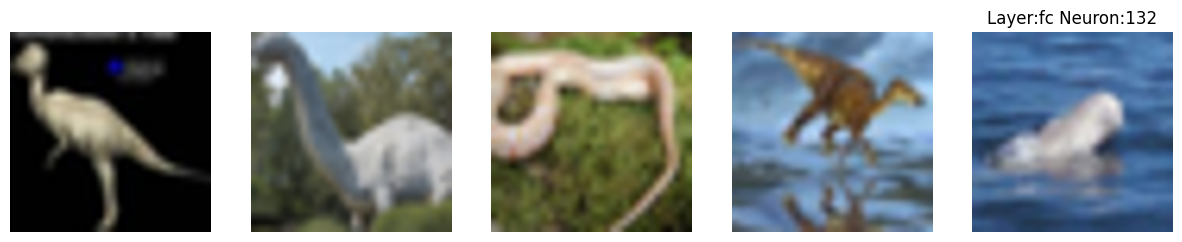

In [6]:
ranks = ["1st", "2nd", "3rd"]
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

for orig_id in ids_to_check:

    print('\n Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
    print('\n Ground Truth: ',lbl_rgx(lbls[orig_id]))
    vals, ids = torch.topk(similarities[orig_id], k=3, largest=True)
    for i in range(len(vals)):
        print("{} description: {}, sim:{:.3f}".format(ranks[i], words[int(ids[i])], vals[i]))
    
    print("2 most highly activating images in D_probe:")
    fig = plt.figure(figsize=(15, 7))
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        fig.add_subplot(1, 5, i+1)
        plt.imshow(im)
        plt.axis('off')
        
    plt.title('Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
    plt.show()

### **(b) Extending the analysis of Fig. 4**

* Now, try to label 2 or 3 other neurons (different from the ones used above) and observe whether the results are reasonable or failure cases.


 Layer:fc Neuron:113

 Ground Truth:  snail
1st description: snail, sim:6.798
2nd description: chambered nautilus, pearly nautilus, nautilus, sim:4.510
3rd description: slug, sim:4.416


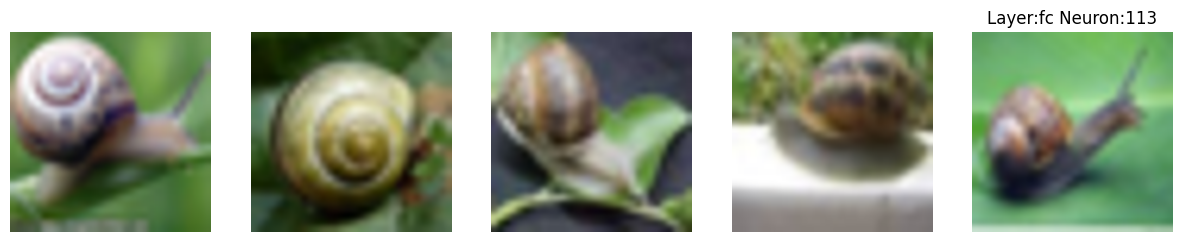


 Layer:fc Neuron:124

 Ground Truth:  crayfish
1st description: American lobster, Northern lobster, Maine lobster, Homarus americanus, sim:4.950
2nd description: spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish, sim:4.855
3rd description: crayfish, crawfish, crawdad, crawdaddy, sim:4.807


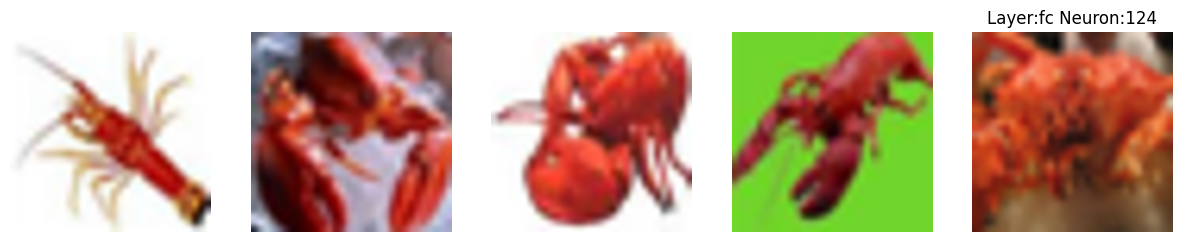


 Layer:fc Neuron:135

 Ground Truth:  limpkin
1st description: limpkin, Aramus pictus, sim:2.635
2nd description: jacamar, sim:1.884
3rd description: European gallinule, Porphyrio porphyrio, sim:1.747


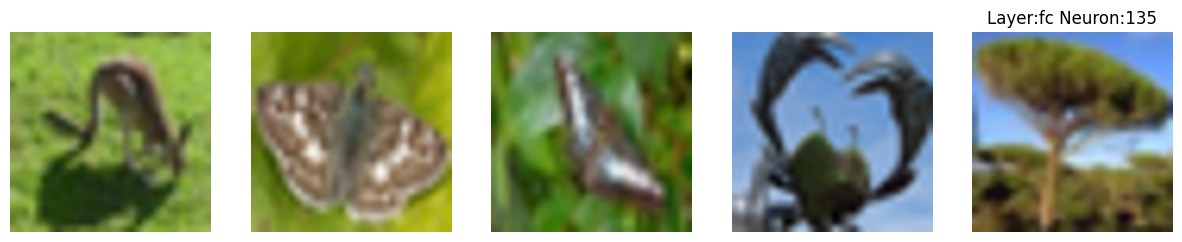

In [7]:
# !!! YOUR CODE HERE !!!
ids_to_more_check = [113,124,135]
ranks = ["1st", "2nd", "3rd"]
for orig_id in ids_to_more_check:
    print('\n Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
    print('\n Ground Truth: ',lbl_rgx(lbls[orig_id]))
    vals, ids = torch.topk(similarities[orig_id], k=3, largest=True)
    for i in range(len(vals)):
        print("{} description: {}, sim:{:.3f}".format(ranks[i], words[int(ids[i])], vals[i]))

    fig = plt.figure(figsize=(15, 7))
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        fig.add_subplot(1, 5, i+1)
        plt.imshow(im)
        plt.axis('off')
        
    plt.title('Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
    plt.show()

### **(c) Analysis of Results**

* Briefly comment on the results from parts (a) and (b). For example, are the results same as the paper? and what extra observations did you make from part (b)?

### Your answer here!

---
---

In [39]:
# Part 1, how many last layer neurons (out of 1000) are correctly described by CLIP-dissect?
check = range(0,1000)
num_corr = 0
for i in check:
    vals, ids = torch.topk(similarities[i], k=3, largest=True)
    split_id = words[ids[0]].split(',')
    # Checking if the first choice of CLIP-dissect matches with the ground truth
    if split_id[0] == lbl_rgx(lbls[i]):
        # Adds counter if so
        num_corr += 1
print('number of correct labels : ', num_corr)
print('number of last layer nerous : ', len(check))
print('percentage : ' , num_corr/len(check))

number of correct labels :  462
number of last layer nerous :  1000
percentage :  0.462


In [62]:
# Part 2, how many last layer neurons are not accurately described but somehow related
# Lets say first guessing within first 3 guess means they are not accurately described but somehow related
# Part 3, if not, then it is considered as failure cases
ids_check = range(0, 1000)
num_matched = 0

for orig_id in ids_check:
    vals, ids = torch.topk(similarities[orig_id], k=3, largest=True)

    # Extract the first guess (word before the first comma) from each description
    first_guesses = [words[int(id)].split(',')[0] for id in ids]

    # Check if any of the first guesses matches the ground truth
    if lbl_rgx(lbls[orig_id]) in first_guesses:
        num_matched += 1

print('Number of neurons where at least one first guess matches the ground truth: ', num_matched)
print('Number of last layer neurons: ', len(ids_check))
print('Percentage: ', num_matched / len(ids_check))
print('Failure case :', 1000 - num_matched)
print('Failture pct: ', 1 - num_matched / len(ids_check))

Number of neurons where at least one first guess matches the ground truth:  712
Number of last layer neurons:  1000
Percentage:  0.712
Failure case : 288
Failture pct:  0.28800000000000003


In [61]:
# Checking if the above code is correct
ids_check = range(0,10)
for orig_id in ids_check:
    print('\n Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
    print('\n Ground Truth: ',lbl_rgx(lbls[orig_id]))
    vals, ids = torch.topk(similarities[orig_id], k=3, largest=True)
    for i in range(len(vals)):
        print("{} description: {}, sim:{:.3f}".format(ranks[i], words[int(ids[i])], vals[i]))



 Layer:fc Neuron:0

 Ground Truth:  tench
1st description: tench, Tinca tinca, sim:5.788
2nd description: coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch, sim:5.349
3rd description: gar, garfish, garpike, billfish, Lepisosteus osseus, sim:4.143

 Layer:fc Neuron:1

 Ground Truth:  goldfish
1st description: anemone fish, sim:6.697
2nd description: goldfish, Carassius auratus, sim:6.665
3rd description: tench, Tinca tinca, sim:5.303

 Layer:fc Neuron:2

 Ground Truth:  great white shark
1st description: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias, sim:6.017
2nd description: tiger shark, Galeocerdo cuvieri, sim:5.560
3rd description: hammerhead, hammerhead shark, sim:5.379

 Layer:fc Neuron:3

 Ground Truth:  tiger shark
1st description: tiger shark, Galeocerdo cuvieri, sim:5.818
2nd description: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias, sim:5.571
3rd description: hammerhead, hamme